In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.mlab import griddata

In [2]:
import tensorflow.contrib.distributions as ds

In [3]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [4]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)

In [5]:
import tensorflow as tf

In [6]:
import tensorflow.contrib.layers as layers

In [7]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [8]:
# batch size for evaluation of mutual entropy
MINE_batch_size = num_samples

# batch size for the training of the encoder / classifier pair
batch_size = 200

bottleneck_size = 2

In [9]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
labels_in = tf.placeholder(tf.int32, [None, ], name = 'labels_in')

In [10]:
def classifier(classifier_input):
    with tf.variable_scope("classifier"):
        lay = layers.relu(classifier_input, 20)
        lay = layers.relu(lay, 20)
        lay = layers.relu(lay, 2)
        outputs = layers.softmax(lay)
        
        these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "classifier")

    return outputs, these_vars

In [11]:
# computes the KL divergence D_KL(P||Q) between the distributions of P and Q, 
# given an equal number of samples drawn from them
def KL_network(data_P, data_Q, name):
    with tf.variable_scope(name):  
        data_combined = tf.concat([data_P, data_Q], axis = 0)
        
        lay = layers.relu(data_combined, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [12]:
def KL_loss(KL_output, name):
    with tf.variable_scope(name):
        batch_size_dyn = tf.cast(tf.math.divide(tf.shape(KL_output)[0], 2), tf.int32)
        
        T_P = KL_output[:batch_size_dyn,:]
        T_Q = KL_output[batch_size_dyn:,:]
        
        TF_loss = -(tf.reduce_mean(T_P, axis = 0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_Q), axis = 0)))
        
        TF_loss = TF_loss[0]
        
    return TF_loss

In [13]:
with tf.variable_scope('model_params'):
    low = tf.Variable(0.0, 'low')
    high = tf.Variable(1.0, 'high')

model_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'model_params')

In [14]:
model = ds.Uniform(low = low, high = high)

In [15]:
samples_model = model.sample((50000,1))

In [16]:
classifier_output, classifier_vars = classifier(data_in)

In [17]:
classifier_output_expanded = tf.expand_dims(classifier_output[:,0], axis = 1)

In [18]:
KL_output, KL_vars = KL_network(classifier_output_expanded, samples_model, name = 'KL')

In [19]:
KL_lossval = KL_loss(KL_output, 'KL_loss')

In [20]:
labels_one_hot = tf.one_hot(labels_in, depth = 2)

In [21]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = classifier_output)

In [22]:
KL_regularized_loss = classification_loss - KL_lossval

In [33]:
train_classifier = tf.train.AdamOptimizer(learning_rate = 0.0005, beta1 = 0.9, beta2 = 0.999).minimize(classification_loss, var_list = classifier_vars)

In [34]:
train_regularized_classifier = tf.train.AdamOptimizer(learning_rate = 0.0005, beta1 = 0.9, beta2 = 0.999).minimize(KL_regularized_loss, var_list = classifier_vars)

In [35]:
train_KL = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999).minimize(KL_lossval, var_list = KL_vars)

In [36]:
# combined training
classification_loss_evolution = []
MI_evolution = []
number_batches = 200
MINE_batches = 300

In [37]:
number_epochs = 10

In [43]:
sess.run(tf.global_variables_initializer())

In [44]:
train_bkg = labels_train == 0
bkg = data_train[train_bkg]

In [45]:
# pre-train KL
for batch in range(500):
    inds = np.random.choice(len(bkg), 50000)
    bkg_train = bkg[inds]
    
    sess.run(train_KL, feed_dict = {data_in: bkg_train})
    
    if not batch % 100:
        cur_KL = -sess.run(KL_lossval, feed_dict = {data_in: bkg})
        print("KL = {}".format(cur_KL))

KL = 0.005061395466327667
KL = 1.5067826509475708
KL = 1.7006685733795166
KL = 1.7273335456848145
KL = 1.7815920114517212


In [46]:
cur_KL = -sess.run(KL_lossval, feed_dict = {data_in: bkg})
print("KL after pre-training = {}".format(cur_KL))

KL after pre-training = 1.911511778831482


In [47]:
for epoch in range(2):
    print("epoch {}".format(epoch))
    
    for batch in range(number_batches):
        # train classifier on sig + bkg
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        labels_batch = labels_train[inds]
        nuisances_batch = nuisances_train[inds]
        sess.run(train_classifier, feed_dict = {data_in: data_batch, labels_in: labels_batch})
        
        # update KL
        for i in range(20):
            inds = np.random.choice(len(bkg), 50000)
            bkg_train = bkg[inds]
            sess.run(train_KL, feed_dict = {data_in: bkg_train})
        
        # train regularized classifier on bkg only
        bkg = data_train[train_bkg]
        labels_bkg = labels_train[train_bkg]
        inds = np.random.choice(len(bkg), 50000)
        bkg_train = bkg[inds]
        labels_bkg_train = labels_bkg[inds]
        sess.run(train_regularized_classifier, feed_dict = {data_in: bkg_train, labels_in: labels_bkg_train})
        
        if not batch % 100:
            cur_KL = -sess.run(KL_lossval, feed_dict = {data_in: bkg})
            class_loss = sess.run(classification_loss, feed_dict = {data_in: data_train, labels_in: labels_train})
            print("class_loss = {}, KL = {}".format(class_loss, cur_KL))

epoch 0
class_loss = 0.6947744488716125, KL = 1.918702483177185
class_loss = 0.6653884649276733, KL = 1.067345142364502
epoch 1
class_loss = 0.6621788144111633, KL = 0.9554462432861328
class_loss = 0.6605706214904785, KL = 0.873809814453125


In [48]:
data_test = np.loadtxt("data_test.txt")
nuisances_test = np.loadtxt("nuisances_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [49]:
pred = sess.run(classifier_output, feed_dict = {data_in: data_test})

In [50]:
pred

array([[0.5       , 0.5       ],
       [0.28263924, 0.71736073],
       [0.2658787 , 0.73412126],
       ...,
       [0.42714542, 0.5728546 ],
       [0.4402663 , 0.5597337 ],
       [0.48735985, 0.5126401 ]], dtype=float32)

In [ ]:
xi = np.linspace(-4, 4, 1000)
yi = np.linspace(-4, 6, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], pred[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [51]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [52]:
pred_sig = sess.run(classifier_output, feed_dict = {data_in: sig})
pred_bkg = sess.run(classifier_output, feed_dict = {data_in: bkg})

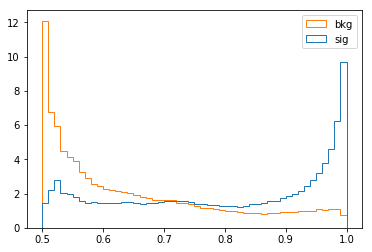

In [53]:
plt.hist([pred_sig[:,1], pred_bkg[:,1]], label = ['sig', 'bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 50)
plt.legend()
plt.show()

In [ ]:
# plot ROC curves
from sklearn import metrics

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred[:,1])

In [ ]:
metrics.roc_auc_score(labels_test, pred[:,1])

In [ ]:
# and load back the values of the (exact) ML estimator evaluated on them
LL_pred = np.loadtxt("LL_evaluated.csv")

In [ ]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

In [ ]:
metrics.roc_auc_score(labels_test, LL_pred)

In [ ]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'shaped classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()